In [229]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/arthur/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [230]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import utils as tutils
from torch import optim
from torchvision import transforms
from torchvision import datasets
from torchvision import utils as vutils
from torchvision import models

In [231]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST('mnist', train=True, download=True, transform=transform)
trainloader = tutils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)

mnist_test = datasets.MNIST('mnist', train=False, download=True, transform=transform)
testloader = tutils.data.DataLoader(mnist_test, batch_size=8, shuffle=True)

classes_mnist = tuple(i for i in range(10))

In [232]:
shape = mnist_train[0][0].shape
shape

torch.Size([1, 28, 28])

In [233]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(1 * 28 * 28, 500),
            nn.ReLU(True),
            nn.Linear(500, 120),
            nn.ReLU(True)
        )
        
        self.z_mean = nn.Linear(120, 30)
        self.z_log_var = nn.Linear(120, 30)
 
        self.decoder = nn.Sequential(
            nn.Linear(30, 120),
            nn.ReLU(True),
            nn.Linear(120, 500),
            nn.ReLU(True),
            nn.Linear(500, 1 * 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        
        if self.training:
            z_std = torch.exp(0.5 * z_log_var)
            eps = torch.randn_like(z_std)
            z = eps * z_std + z_mean
        else:
            z = z_mean

        return self.decoder(z), z_mean, z_log_var

In [234]:
def floss(compressed_images, images, mean, log_var):
    bce = F.binary_cross_entropy(compressed_images, images, size_average=False)
    #mse = F.mse_loss(compressed_images, images)
    # Kullback divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return bce + kl

In [235]:
net = VariationalAutoEncoder()
print(net)

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=120, bias=True)
    (3): ReLU(inplace)
  )
  (z_mean): Linear(in_features=120, out_features=30, bias=True)
  (z_log_var): Linear(in_features=120, out_features=30, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=120, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=120, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [236]:
optimizer = optim.Adam(net.parameters())

In [237]:
n_epochs = 10
net.train()
for epoch in range(n_epochs):
    running_loss = 0.
    
    for images, _ in trainloader:
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        outputs, mean, log_var = net(images)
        loss = floss(outputs, images, mean, log_var)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.item()
    print('Epoch: {}, Loss: {}'.format(epoch, running_loss))

Epoch: 0, Loss: 10835434.0
Epoch: 1, Loss: 7973456.4130859375
Epoch: 2, Loss: 7208757.7021484375
Epoch: 3, Loss: 6832445.4453125
Epoch: 4, Loss: 6628708.3046875
Epoch: 5, Loss: 6507719.6884765625
Epoch: 6, Loss: 6422806.1357421875
Epoch: 7, Loss: 6360037.6689453125
Epoch: 8, Loss: 6309704.9736328125
Epoch: 9, Loss: 6265404.115234375


In [238]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)

def display_batch(images, reshape=False):
    if reshape:
        images = images.view(images.shape[0], 1, 28, 28)
    imshow(vutils.make_grid(images))

In [239]:
images, labels = next(iter(testloader))

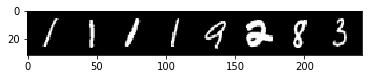

In [240]:
display_batch(images)

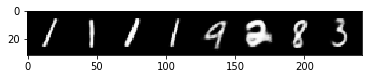

In [241]:
net.eval()
compressed_images, _, _ = net(images.view(images.shape[0], -1))
display_batch(compressed_images.detach(), reshape=True)

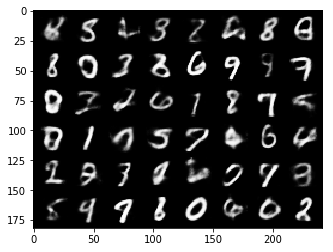

In [244]:
rnd = torch.randn((48, 30))
display_batch(net.decoder(rnd).detach(), reshape=True)

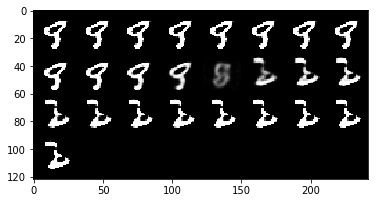

In [242]:
n_points = 25
h_dim = 30
lim = 15
rnd = torch.randn((h_dim,))
x = torch.empty((n_points, h_dim))

stds = torch.from_numpy(
    np.linspace(-lim, lim, n_points)
).float()
for i in range(n_points):
    x[i] = rnd * stds[i]

i = net.decoder(x)
display_batch(i.detach(), reshape=True)